# Doom Playing Reinforcement Learning Model - Basic Level

## 1. Prepare Enviorment

In [70]:
# To install viz doom
# !pip install vizdoom

# Clone the VizDoom GitHub repo from this URL
# https://github.com/mwydmuch/ViZDoom

In [71]:
# Import necessary Libraries
import random # allows for action sampling
import time # # allows for sleeping between frames
import numpy as np # import for identity array matrix
from vizdoom import * # import for game enviornment
from matplotlib import pyplot as plt # import for vizualizations

In [72]:
game = DoomGame() # Define game
game.load_config('ViZDoom-master/ViZDoom-master/scenarios/basic.cfg') # Load Game configuration
game.init() # Initial Game 

In [73]:
# Set of possible actions in current Doom game enviornment
actions = np.identity(3, dtype=np.uint8)

#### Start new game episode

In [74]:
game.new_episode()

In [75]:
game.is_episode_finished()

False

In [76]:
game.get_state().screen_buffer.shape

(3, 240, 320)

In [77]:
state = game.get_state()

In [ ]:
# Loop to run through episodes (basic level)

episodes = 10 # Play 10 games
for episode in range(episodes):
    game.new_episode() # Start from scratch
    while not game.is_episode_finished(): # Check if game is finished
        state = game.get_state() # Get current frame / game state
        img = state.screen_buffer # Get specific image
        info = state.game_variables # Get info on game state=
        # Take random action and assoicate that with reward 
        # Can add frame skip param to speed up 
        reward = game.make_action(random.choice(actions)) 
        print('Reward:', reward)
        time.sleep(0.002) # Take brief break before exiting while loop and printing game result
    print('Result:', game.get_total_reward())
    time.sleep(2) # Sleep 2 seconds before next iteration in for loop

In [78]:
game.close()

## 2. Convert game to OpenAI Gym enviornment

In [79]:
from gym import Env # Base class enviornment from OpenAI Gym
from gym.spaces import Discrete, Box # Allows us to define shapes from our enviornments
import cv2 # Allows for computer vision

#### Testing Box and Discrete

In [80]:
Box(low=0, high=10, shape=(10,10), dtype=np.uint8).sample()

array([[ 0,  6,  2,  7,  4,  5,  2,  2,  2,  0],
       [ 2,  9,  0,  8,  9,  6,  4,  0,  5,  5],
       [ 6,  7,  0,  0,  1,  9,  9,  3,  4,  0],
       [ 9,  4, 10,  4,  6,  7,  1,  9,  8,  3],
       [ 1,  3,  9,  2, 10,  6,  8,  7,  4,  6],
       [ 4,  9,  8,  5,  2,  6,  3,  1,  7,  8],
       [ 2,  7,  7, 10,  4,  6,  2,  3,  8,  6],
       [ 7,  7,  4,  3,  6,  3,  9,  7,  0,  2],
       [ 2,  6, 10,  0,  8,  9, 10,  4, 10,  6],
       [10,  7,  1,  2,  7,  3,  8,  0,  5,  2]], dtype=uint8)

In [81]:
Discrete(3).sample()

1

In [82]:
actions[Discrete(3).sample()]

array([0, 0, 1], dtype=uint8)

#### Define vizDoom Enviornment Class

In [83]:
class VizDoomGym(Env):
    
    # Function called at initialization(start) of Env
    def __init__(self, render=False):
        # Inherit from Env
        super().__init__()
        # Set up game
        self.game = DoomGame() # Define game
        # Load Game configuration; able to change
        self.game.load_config('ViZDoom-master/ViZDoom-master/scenarios/basic.cfg') 
        
        # Define whether or not to render the game - Rendering hinders training speed
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Initial Game (Start Game)
        self.game.init() 
        
        # Create and define observation and activation space for game
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8)
        self.action_space = Discrete(3)
    
    # Function - how we take steps in enviornment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(3, dtype=np.uint8) # Define actions
        reward = self.game.make_action(actions[action], 4) # Define reward based on action
        
        # Get and return relevent game information, variables
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer # Define current game state
            state = self.grayscale(state) # Apply gray scale to step function
            ammo = self.game.get_state().game_variables[0] # Return ammo game variables
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
        
        info = {"info":info}
        done = self.game.is_episode_finished() # Determine whether game is finsihed
        
        return state, reward, done, info
    
    # Don't need to define render function - predefined in vizDoom
    # Normally, the function to render a game / enviornment
    def render():
        pass
    
    # Function - what happens when new game is started
    def reset(self):
        self.game.new_episode() # Start new game
        state = self.game.get_state().screen_buffer
        return self.grayscale(state) # Apply grayscale to reset function
    
    # Function - grayscale and resize game frame
    def grayscale(self, observation):
        # Concert to grayscale
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        # Resize to remove bottom info bar from game observation
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
     
    # Function - Call to close down game
    def close(self):
        self.game.close()

#### Test enviornment and return relevant information

In [84]:
env = VizDoomGym(render=False)

In [85]:
env.observation_space.sample().shape

(100, 160, 1)

In [86]:
env.action_space

Discrete(3)

## 3. View State

In [87]:
state = env.reset()

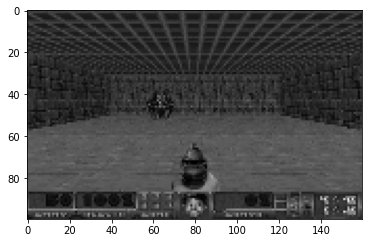

In [88]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [91]:
env.close()

In [89]:
# Import enviornment checker
from stable_baselines3.common import env_checker

In [90]:
# Check for valid env - no error is good
env_checker.check_env(env)

## 4. Setup Callback

In [92]:
# import necessary libraries
import os
from stable_baselines3.common.callbacks import BaseCallback

In [93]:
# Define class for training and logging callback
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [94]:
# Dirs for saving trained RL models
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [95]:
# Create instance of train and logging callback - save pytorch model every 10,000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

## 5. Train Reinforcement Learning Model

In [96]:
# Import ppo for training
from stable_baselines3 import PPO

In [97]:
# Create non rendered enviornment
env = VizDoomGym()

In [98]:
# Define model and policy 
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [99]:
# Train model
model.learn(total_timesteps=50000, callback=callback)

Logging to ./logs/log_basic\PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.6     |
|    ep_rew_mean     | -67.8    |
| time/              |          |
|    fps             | 35       |
|    iterations      | 1        |
|    time_elapsed    | 57       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.6        |
|    ep_rew_mean          | -53.6       |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 2           |
|    time_elapsed         | 122         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009592133 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000133 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.2        |
|    ep_rew_mean          | 24.9        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 11          |
|    time_elapsed         | 788         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.040622458 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.883      |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.0001      |
|    loss                 | 808         |
|    n_updates            | 100         |
|    policy_gradient_loss | 0.0219      |
|    value_loss           | 2.46e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.8  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.9         |
|    ep_rew_mean          | 74.8        |
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 21          |
|    time_elapsed         | 1607        |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.056591697 |
|    clip_fraction        | 0.298       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.528      |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.0001      |
|    loss                 | 126         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.000893   |
|    value_loss           | 302         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.03  

## 6. Test Model

In [100]:
# import evaluation policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy
import time

In [101]:
# Reload model from disc drive
model = PPO.load('./train/train_basic/best_model_50000')

In [102]:
# Create rendered enviornment
env = VizDoomGym(render=True)

In [103]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)

In [104]:
# Display mean reward
mean_reward

82.69

In [112]:
# Loop to test agent without using evaluate_policy
for episode in range(100): 
    obs = env.reset() # observations
    done = False # havent completed
    total_reward = 0 
    while not done: 
        action, _ = model.predict(obs) # get action
        obs, reward, done, info = env.step(action) # pass into env step function
        #time.sleep(0.20)
        total_reward += reward # update reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is 95.0
Total Reward for episode 1 is 95.0
Total Reward for episode 2 is 75.0
Total Reward for episode 3 is 63.0
Total Reward for episode 4 is 79.0
Total Reward for episode 5 is 95.0
Total Reward for episode 6 is 95.0
Total Reward for episode 7 is 95.0
Total Reward for episode 8 is 95.0
Total Reward for episode 9 is 91.0
Total Reward for episode 10 is 67.0
Total Reward for episode 11 is 75.0
Total Reward for episode 12 is 83.0
Total Reward for episode 13 is 91.0
Total Reward for episode 14 is 95.0
Total Reward for episode 15 is 95.0
Total Reward for episode 16 is 52.0
Total Reward for episode 17 is 95.0
Total Reward for episode 18 is 59.0
Total Reward for episode 19 is 95.0
Total Reward for episode 20 is 95.0
Total Reward for episode 21 is 71.0
Total Reward for episode 22 is 95.0
Total Reward for episode 23 is 95.0
Total Reward for episode 24 is 95.0
Total Reward for episode 25 is 43.0
Total Reward for episode 26 is -300.0
Total Reward for episode 27 is 79.0


In [113]:
env.close()